<a href="https://colab.research.google.com/github/Rhitabrat/MAMI/blob/main/Text%20plus%20Visual%20Embeddings/image_text_from_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generate baseline for image plus text data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
'''
requires the same folder:
- script evaluation
-folder 'ref' with truth.txt
-folder 'TRAINING' with images
'''

# import evaluation
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import regularizers
import os
import gc
import shutil 


In [11]:
# paths
csv_path_test = '/content/drive/MyDrive/PSU/NLP Lab/MAMI/TEST/CSV/Test.csv'
csv_path_train = '/content/drive/MyDrive/PSU/NLP Lab/MAMI/TRAIN/CSVs/training_original.csv'
image_path = '/content/drive/MyDrive/PSU/NLP Lab/MAMI/TRAIN/Images'


def loadImage(image_path):
    try:
        return load_img(image_path, target_size=(image_size, image_size))
    except:
        image_path = image_path.replace('png', 'jpg')
        return load_img(image_path, target_size=(image_size, image_size))

# if not os.path.exists('./ImageTextModel'):
    # os.makedirs('./ImageTextModel')

if not os.path.exists('/content/drive/MyDrive/PSU/NLP Lab/MAMI/Saved Models/ImageTextModel'):
    os.makedirs('/content/drive/MyDrive/PSU/NLP Lab/MAMI/Saved Models/ImageTextModel')
    
batch_size = 32
epochs = 50
image_size = 224
embed_size = 768 #according to USE
threshold = 0.5

#Universal Sentence Encoder
tf.compat.v1.disable_eager_execution()

module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3?tf-hub-format=compressed"
# module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4?tf-hub-format=compressed"
embed = hub.Module(module_url)

In [9]:

#_______________________________Load Train Data_______________________________
train_df = pd.read_csv(csv_path_train, usecols=['file_name', 'misogynous', 'Text Transcription'], sep='\t')
path = image_path+'/'

train_df['image_path'] = path + train_df['file_name']

# Universal Sentence Encoder (USE)
'''
Split the dataset to avoid hitting the USE call limit
an error occurs if the 47900 steps are reached
'''
dfs = np.array_split(train_df, 10)
train_df['USE'] = None
text_embeddings=[]
with tf.compat.v1.Session() as session:
    session.run([tf.compat.v1.global_variables_initializer(), tf.compat.v1.tables_initializer()])
   
    for x in dfs:
      x_data_matches = pd.Series([])
      text_embedding = session.run(embed(list(x['Text Transcription'])))
      text_embeddings = text_embeddings + np.array(text_embedding).tolist()
      
train_df['USE'] = text_embeddings

#load images
train_df['image'] = None
train_df['image'] = train_df['image_path'].apply(lambda x: img_to_array(loadImage(x)))        

#division and processing of data as input to the model
X_train = train_df[['file_name', 'USE', 'image']]
y_train = train_df['misogynous']

#text
tmp = []
for value in X_train['USE']:
    tmp.append([value])  
tX_train = np.array(tmp)

#images
tmp = []
for value in X_train['image']:
  tmp.append(value) 
iX_train = np.array(tmp)

#misogynous label
tmp = []
for value in y_train:
    tmp.append([value])  
y_train = np.array(tmp)

#clear memory
del train_df
del dfs
del text_embedding
del text_embeddings

gc.collect()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TypeError: ignored

In [47]:
#_______________________________IMAGE MODEL_______________________________
l2_strength = 1e-5

input_image = layers.Input(shape=(image_size,image_size,3))
vgg_model = VGG16(input_tensor = input_image, weights = 'imagenet', include_top=False)

for layer in vgg_model.layers:
    layer.trainable = False

x = vgg_model.output
x = layers.Flatten(input_shape=vgg_model.output_shape[1:])(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_strength))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_strength))(x)
x = layers.Dense(1, activation='sigmoid')(x)
image_model = Model(vgg_model.input, x)

image_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
image_model.summary()

history = image_model.fit(iX_train, 
                    y_train,
                    validation_split=0.1,
                    epochs= 30,
                    batch_size=batch_size,
                    #verbose=0,
                    )
                    
# image_model.save('/content/drive/MyDrive/PSU/NLP Lab/MAMI/Saved Models/ImageTextModel/image_model.h5')



Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


9000/9000 [==============================] - 35s 4ms/sample - loss: 3.4260 - accuracy: 0.5660 - val_loss: 0.6776 - val_accuracy: 0.5640
Epoch 2/30
9000/9000 [==============================] - 21s 2ms/sample - loss: 0.8286 - accuracy: 0.5932 - val_loss: 0.6623 - val_accuracy: 0.6600
Epoch 3/30
9000/9000 [==============================] - 21s 2ms/sample - loss: 0.6957 - accuracy: 0.6408 - val_loss: 0.7802 - val_accuracy: 0.6550
Epoch 4/30
9000/9000 [==============================] - 21s 2ms/sample - loss: 0.7171 - accuracy: 0.6546 - val_loss: 0.6298 - val_accuracy: 0.6690
Epoch 5/30
9000/9000 [==============================] - 21s 2ms/sample - loss: 0.7090 - accuracy: 0.6609 - val_loss: 0.6176 - val_accuracy: 0.6930
Epoch 6/30
9000/9000 [==============================] - 21s 2ms/sample - loss: 0.6525 - accuracy: 0.6777 - val_loss: 0.6475 - val_accuracy: 0.6630
Epoch 7/30
9000/9000 [==============================] - 21s 2ms/sample - loss: 0.6487 - accuracy: 0.6873 - val_loss: 0.6131 - val

In [48]:
#_______________________________TEXT MODEL_______________________________
input_text = layers.Input(shape=(1, embed_size))
l = layers.Dense(1, activation='sigmoid')(input_text)
text_model = Model(inputs=[input_text], outputs=l)
text_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
text_model.summary()

history = text_model.fit(tX_train, 
                    y_train,
                    validation_split=0.1,
                    epochs= 30,
                    batch_size=batch_size,
                    #verbose=0
                    )

text_model.save('/content/drive/MyDrive/PSU/NLP Lab/MAMI/Saved Models/ImageTextModel/text_model.h5')




Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 512)]          0         
                                                                 
 dense_11 (Dense)            (None, 1, 1)              513       
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/30
8896/9000 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5027

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


9000/9000 [==============================] - 4s 453us/sample - loss: 0.6933 - accuracy: 0.5027 - val_loss: 0.6941 - val_accuracy: 0.4833
Epoch 2/30
9000/9000 [==============================] - 1s 69us/sample - loss: 0.6933 - accuracy: 0.5030 - val_loss: 0.6945 - val_accuracy: 0.4816
Epoch 3/30
9000/9000 [==============================] - 1s 66us/sample - loss: 0.6933 - accuracy: 0.5026 - val_loss: 0.6931 - val_accuracy: 0.5038
Epoch 4/30
9000/9000 [==============================] - 1s 60us/sample - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6939 - val_accuracy: 0.4903
Epoch 5/30
9000/9000 [==============================] - 1s 63us/sample - loss: 0.6932 - accuracy: 0.5044 - val_loss: 0.6955 - val_accuracy: 0.4794
Epoch 6/30
9000/9000 [==============================] - 1s 62us/sample - loss: 0.6933 - accuracy: 0.5028 - val_loss: 0.6938 - val_accuracy: 0.4895
Epoch 7/30
9000/9000 [==============================] - 1s 60us/sample - loss: 0.6932 - accuracy: 0.5053 - val_loss: 0.6942 - va

In [49]:
image = image_model.layers[len(image_model.layers)-2].output
reshape = layers.Reshape((1, image_model.layers[len(image_model.layers)-2].output_shape[1]), name='predictions')(image)
text = text_model.layers[0].output

input = tf.keras.layers.Concatenate(axis=-1)([text, reshape])

l = layers.Dense(1, activation='sigmoid')(input)
model = Model(inputs=[input_text, input_image], outputs=[l])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [50]:
text

<tf.Tensor 'input_2:0' shape=(None, 1, 512) dtype=float32>

In [51]:
reshape

<tf.Tensor 'predictions/Reshape:0' shape=(None, 1, 64) dtype=float32>

In [52]:
input_text

<tf.Tensor 'input_2:0' shape=(None, 1, 512) dtype=float32>

In [53]:
input_image

<tf.Tensor 'input_1:0' shape=(None, 224, 224, 3) dtype=float32>

In [54]:
l

<tf.Tensor 'dense_12/Sigmoid:0' shape=(None, 1, 1) dtype=float32>

In [ ]:
# !pip install tensorflow_text

In [55]:
import tensorflow_text

# downloading the pre-trained BERT model from tfhub
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [56]:
# initializing BERT layers
text_input_bert = tf.keras.layers.Input(shape=(), dtype=tf.string, name='input_text') # input layer
preprocessed_text = bert_preprocess(text_input_bert)
outputs = bert_encoder(preprocessed_text)

reshape = tf.keras.layers.Reshape(target_shape=(1, 768))(outputs['default'])

# initializing NN layer
l = tf.keras.layers.Dropout(0.1, name="dropout")(reshape)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

text_model_bert = Model(inputs=[text_input_bert], outputs=l)
text_model_bert.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
text_model_bert.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_text (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_mask': (Non  0           ['input_text[0][0]']             
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [7]:
df_1 = pd.read_csv(csv_path_train, usecols=['file_name', 'misogynous', 'Text Transcription'], sep='\t')

In [8]:
history = text_model.fit(df_1['Text Transcription'],
                         df_1['misogynous'],
                         validation_split=0.1,
                         epochs= 10,
                         batch_size=batch_size,
                         #verbose=0
                         )

Epoch 1/10
282/282 [==============================] - 72s 223ms/step - loss: 0.6821 - accuracy: 0.5636 - val_loss: 0.6581 - val_accuracy: 0.6140
Epoch 2/10
282/282 [==============================] - 61s 218ms/step - loss: 0.6570 - accuracy: 0.6137 - val_loss: 0.6493 - val_accuracy: 0.6110
Epoch 3/10
282/282 [==============================] - 61s 218ms/step - loss: 0.6446 - accuracy: 0.6294 - val_loss: 0.6370 - val_accuracy: 0.6610
Epoch 4/10
282/282 [==============================] - 61s 218ms/step - loss: 0.6333 - accuracy: 0.6468 - val_loss: 0.6269 - val_accuracy: 0.6710
Epoch 5/10
282/282 [==============================] - 61s 218ms/step - loss: 0.6228 - accuracy: 0.6617 - val_loss: 0.6225 - val_accuracy: 0.6740
Epoch 6/10
282/282 [==============================] - 61s 218ms/step - loss: 0.6183 - accuracy: 0.6676 - val_loss: 0.6218 - val_accuracy: 0.6720
Epoch 7/10
282/282 [==============================] - 61s 218ms/step - loss: 0.6059 - accuracy: 0.6786 - val_loss: 0.6307 - val_ac

In [60]:
text_model.layers[5].output

<KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'output')>

In [16]:
# input_image = layers.Input(shape=(image_size,image_size,3))
# vgg_model = VGG16(input_tensor = input_image, weights = 'imagenet', include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [23]:
# txt_model = tf.keras.models.load_model('/content/drive/MyDrive/PSU/NLP Lab/MAMI/Saved Models/ImageTextModel/text_model.h5')
# # txt_model.summary()
# txt_model.layers[0].output

<KerasTensor: shape=(None, 1, 512) dtype=float32 (created by layer 'input_2')>

In [20]:
# # load image_model from dir
# image_model = tf.keras.models.load_model('/content/drive/MyDrive/PSU/NLP Lab/MAMI/Saved Models/ImageTextModel/image_model.h5')
# # image_model.summary()

In [62]:
#_______________________________IMAGE-TEXT MODEL_______________________________
image = image_model.layers[len(image_model.layers)-2].output
reshape = layers.Reshape((1, image_model.layers[len(image_model.layers)-2].output_shape[1]), name='predictions')(image)
text = text_model_bert.layers[3].output

input = tf.keras.layers.Concatenate(axis=-1)([text, reshape])

l = layers.Dense(1, activation='sigmoid')(input)
model = Model(inputs=[text, input_image], outputs=[l])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# model.save('/content/drive/MyDrive/PSU/NLP Lab/MAMI/Saved Models/ImageTextModel/image_text_model.h5')
# tf.keras.utils.plot_model(model, "/content/drive/MyDrive/PSU/NLP Lab/MAMI/Saved Models/ImageTextModel/model.png", show_shapes=True)



Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("reshape_1/Reshape:0", shape=(None, 1, 768), dtype=float32)


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("reshape_1/Reshape:0", shape=(None, 1, 768), dtype=float32)


ValueError: ignored

In [61]:
text_model_bert.layers[3].output

<tf.Tensor 'reshape_1/Reshape:0' shape=(None, 1, 768) dtype=float32>

In [63]:
input

<tf.Tensor 'concatenate_10/concat:0' shape=(None, 1, 832) dtype=float32>

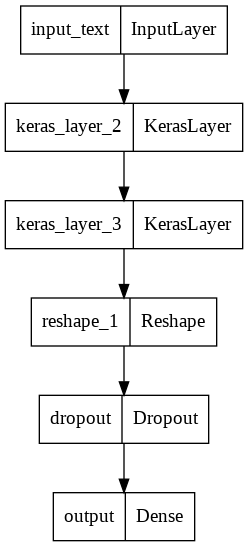

In [69]:
from keras.utils.vis_utils import plot_model
plot_model(text_model_bert)

In [ ]:
#_______________________________Load Test Data_______________________________
#clear memory
# del X_train
# del y_train
# del iX_train
# del tX_train

gc.collect()

# paths
csv_path_test = '/content/drive/MyDrive/PSU/NLP Lab/MAMI/TEST/CSV/Test.csv'
image_path = '/content/drive/MyDrive/PSU/NLP Lab/MAMI/TEST/Images'

#load data
test_df = pd.read_csv(csv_path_test, sep='\t')
path = image_path+'/'
test_df['image_path'] = path + test_df['file_name']

# Universal Sentence Encoder (USE)
'''
Split the dataset to avoid hitting the USE call limit
an error occurs if the 47900 steps are reached
'''
dfs = np.array_split(test_df, 10)
test_df['USE'] = None
text_embeddings=[]
with tf.compat.v1.Session() as session:
    session.run([tf.compat.v1.global_variables_initializer(), tf.compat.v1.tables_initializer()])
   
    for x in dfs:
      x_data_matches = pd.Series([])
      text_embedding = session.run(embed(list(x['Text Transcription'])))
      text_embeddings = text_embeddings + np.array(text_embedding).tolist()
test_df['USE'] = text_embeddings

#Load images
test_df['image'] = None
test_df['image'] = test_df['image_path'].apply(lambda x: img_to_array(loadImage(x)))        

#division and processing of data as input to the model
X_test = test_df[['file_name', 'USE', 'image']]

#Text
tmp = []
for value in X_test['USE']:
    tmp.append([value])  
tX_test = np.array(tmp)


#images
tmp = []
for value in X_test['image']:
    tmp.append(value)  
iX_test = np.array(tmp)

#clear memory
del tmp
del dfs
del text_embedding
del text_embeddings

gc.collect()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


0

In [ ]:
#_______________________________PREDICTION_______________________________
predictions = model.predict([tX_test, iX_test], batch_size=batch_size)
predictions = predictions.reshape(predictions.shape[0])
pred = predictions > threshold
pred = list(map(int, pred)) #true/false to 1/0

predictions_db = pd.DataFrame(data=test_df['file_name'])
predictions_db['misogynist'] = pred


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
predictions_db.to_csv("/content/drive/MyDrive/PSU/NLP Lab/MAMI/result.csv", index=False)
predictions_db

,file_name,misogynist
0,15236.jpg,0
1,15805.jpg,0
2,16254.jpg,1
3,16191.jpg,1
4,15952.jpg,0
...,...,...
995,15591.jpg,0
996,15049.jpg,0
997,15363.jpg,0
998,15199.jpg,0


In [ ]:
import evaluation

#_______________________________EVALUATION_______________________________
if not os.path.exists('./res'):
    os.makedirs('./res')

predictions_db.to_csv('./res/answer.txt', index=False, sep='\t', header=False)
evaluation.main(['','./', '/content/drive/MyDrive/PSU/NLP Lab/MAMI/Saved Models/ImageTextModel/'])
#move res folder to ImageTextModel folder
shutil.move('./res/', '/content/drive/MyDrive/PSU/NLP Lab/MAMI/Saved Models/ImageTextModel/res/')


In [ ]:
# from sklearn.metrics import f1_score

# f1_score(test_df['misogynous'], predictions_db['misogynist'], average='micro')